# Preamble
**Name:** Deborah Djon</br>
**Student Number:** 22261972</br>
**Module Code:** CA694</br>
**Module Name:** Practicum</br>
**Supervisor:** Dr. Geoff Hamilton</br>

## **Plagiarism Policy**
I declare that this material, which I now submit for assessment, is entirely my own work and has not been taken from the work of others, save and to the extent that such work has been cited and acknowledged within the text of my work. I understand that plagiarism, collusion, and copying are grave and serious offences in the university and accept the penalties that would be imposed should I engage in plagiarism, collusion or copying. I have read and understood the Assignment Regulations. I have identified and included the source of all facts, ideas, opinions, and viewpoints of others in the assignment references. Direct quotations from books, journal articles, internet sources, module text, or any other source whatsoever are acknowledged and the source cited are identified in the assignment references. This assignment, or any part of it, has not been previously submitted by me or any other person for assessment on this or any other course of study.</br>

I have read and understood the referencing guidelines found at
http://www.dcu.ie/info/regulations/plagiarism.shtml,
https://www4.dcu.ie/students/az/plagiarism and/or recommended in the assignment
guidelines.

# Data Pre-processing
This notebook is concerned with pre-processing the data for our project. The objectives are: 
- Remove leading zeros in the traces
- Convert all numerical data to floats
- Create a Json file with Video Id mappings to URL ids
- Anonymise data. Rename video ids to video_1-video_n
- Rename columns: 
    - bpts:     Bytes per timestamp
    - ts:       Timestamps
    - video_id: Video Youtube URL id
- Create a datasets aggregate to to milliseconds 10-1000 (100 in total)
    - name: data_XXXX_ms-aggregate
    - Add columns: 
        - bpi:  Bytes per interval
        - bpp:  Bytes per period
        - DF_bpp:   Differential fingerprint
        - DF_bpp_alt: Alternatively proposed fingerprint
        - DF_bpi:   Differential fingerprint
        - DF_bpi_alt: Alternatively proposed fingerprint
- Create widening window datasets for one aggregate dataset. 100-120000 in 100ms steps (max 1200). 
    - Each DF name: data_XXXX_ms-aggregate-windows_size_XXXX_ms
    - Columns: window_fp_DF_bpp, window_fp_DF_bpp_alt, window_fp_DF_bpi, window_fp_DF_bpi_alt, video_id

## Imports

### Libraries

In [14]:
import sys
sys.path.append("../..")
from modelling_utilities.constants import *
from modelling_utilities import data_processing, visualisation
import pandas as pd
import shutil
import os
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Data

In [16]:
cw_p = RAW_DATA_FOLDER+"closed_world_mega_frame.pkl"
cw_df = pd.read_pickle(cw_p)
display(
    cw_df.head()
)

ow_p = RAW_DATA_FOLDER+"open_world_mega_frame.pkl"
ow_df = pd.read_pickle(ow_p)

display(
    ow_df.head()
)

,timestamp,data,video_id
0,"[2023-06-22 11:47:33.180000, 2023-06-22 11:47:...","[0.0, 0.0, 5861.0, 5861.0, 5890.0, 72784.0, 11...",3IosA_ir06Y
1,"[2023-06-22 10:59:57.390000, 2023-06-22 10:59:...","[5861.0, 5861.0, 5932.0, 72784.0, 25446.0, 567...",3IosA_ir06Y
2,"[2023-06-22 11:42:14.490000, 2023-06-22 11:42:...","[0.0, 5861.0, 5664.0, 5861.0, 72784.0, 11322.0...",3IosA_ir06Y
3,"[2023-06-22 12:14:02.060000, 2023-06-22 12:14:...","[0.0, 5861.0, 5861.0, 72784.0, 6067.0, 25446.0...",3IosA_ir06Y
4,"[2023-06-22 12:03:27.860000, 2023-06-22 12:03:...","[0.0, 5861.0, 5861.0, 7479.0, 7392.0, 26827.0,...",3IosA_ir06Y


,timestamp,data,video_id
0,"[2023-06-27 23:39:18.500000, 2023-06-27 23:39:...","[965.0, 55313.0, 61373.0, 10066.0, 10047.0, 10...",pxZdo1n4pME
1,"[2023-06-30 00:21:10.750000, 2023-06-30 00:21:...","[44004.0, 7702.0, 61608.0, 438780.0, 553869.0,...",cTuBm4imTcE
2,"[2023-06-28 00:36:21.290000, 2023-06-28 00:36:...","[965.0, 5529.0, 61371.0, 6390.0, 7349.0, 5862....",BtnXRoKhURs
3,"[2023-06-26 18:13:43.080000, 2023-06-26 18:13:...","[17942.0, 61268.0, 14519.0, 14033.0, 701.0, 70...",OB0gPldTIy4
4,"[2023-06-26 18:10:42.830000, 2023-06-26 18:10:...","[991.0, 61266.0, 702.0, 702.0, 5861.0, 5861.0,...",YgA3uFJ5Hgs


## Rename Columns + Combine Datasets

In [17]:
# Verify datatypes
print("Open World ....................")
for c in cw_df.columns: 
    types = cw_df[c].apply(lambda arr: [type(x) for x in arr ]).apply(set)
    print(f"Types for column {c}")
    print(types.drop_duplicates())
    print()

print("Closed World ....................")
for c in ow_df.columns: 
    types = ow_df[c].apply(lambda arr: [type(x) for x in arr ]).apply(set)
    print(f"Types for column {c}")
    print(types.drop_duplicates())
    print()

Open World ....................
Types for column timestamp
0    {<class 'datetime.datetime'>}
Name: timestamp, dtype: object

Types for column data
0    {<class 'float'>}
Name: data, dtype: object

Types for column video_id
0    {<class 'str'>}
Name: video_id, dtype: object

Closed World ....................
Types for column timestamp
0    {<class 'datetime.datetime'>}
Name: timestamp, dtype: object

Types for column data
0    {<class 'float'>}
Name: data, dtype: object

Types for column video_id
0    {<class 'str'>}
Name: video_id, dtype: object



In [18]:
cw_df["cw"] = 1
cw_df["class"] = cw_df["video_id"]
ow_df["cw"] = 0
ow_df["class"] = "unknown"
data = pd.concat([cw_df, ow_df], axis=0, ignore_index=True)
display(
    data
)

,timestamp,data,video_id,cw,class
0,"[2023-06-22 11:47:33.180000, 2023-06-22 11:47:...","[0.0, 0.0, 5861.0, 5861.0, 5890.0, 72784.0, 11...",3IosA_ir06Y,1,3IosA_ir06Y
1,"[2023-06-22 10:59:57.390000, 2023-06-22 10:59:...","[5861.0, 5861.0, 5932.0, 72784.0, 25446.0, 567...",3IosA_ir06Y,1,3IosA_ir06Y
2,"[2023-06-22 11:42:14.490000, 2023-06-22 11:42:...","[0.0, 5861.0, 5664.0, 5861.0, 72784.0, 11322.0...",3IosA_ir06Y,1,3IosA_ir06Y
3,"[2023-06-22 12:14:02.060000, 2023-06-22 12:14:...","[0.0, 5861.0, 5861.0, 72784.0, 6067.0, 25446.0...",3IosA_ir06Y,1,3IosA_ir06Y
4,"[2023-06-22 12:03:27.860000, 2023-06-22 12:03:...","[0.0, 5861.0, 5861.0, 7479.0, 7392.0, 26827.0,...",3IosA_ir06Y,1,3IosA_ir06Y
...,...,...,...,...,...
6284,"[2023-06-27 17:54:00.340000, 2023-06-27 17:54:...","[46492.0, 61441.0, 4817.0, 6390.0, 737.0, 701....",6abePkXncCM,0,unknown
6285,"[2023-06-26 17:46:42.220000, 2023-06-26 17:46:...","[5530.0, 61266.0, 11734.0, 14305.0, 5001.0, 73...",G6KXLtn6OHU,0,unknown
6286,"[2023-06-28 01:36:25, 2023-06-28 01:36:26.7900...","[30452.0, 61372.0, 4816.0, 6390.0, 736.0, 5862...",tXtgtxWt_Rc,0,unknown
6287,"[2023-06-27 13:26:47.250000, 2023-06-27 13:26:...","[61404.0, 4959.0, 6390.0, 737.0, 73451.0, 1016...",gTWo9oLJOWk,0,unknown


In [19]:
data.rename(columns={'timestamp': 'ts', 'data':'bpts'}, inplace=True)
data.head(2)

,ts,bpts,video_id,cw,class
0,"[2023-06-22 11:47:33.180000, 2023-06-22 11:47:...","[0.0, 0.0, 5861.0, 5861.0, 5890.0, 72784.0, 11...",3IosA_ir06Y,1,3IosA_ir06Y
1,"[2023-06-22 10:59:57.390000, 2023-06-22 10:59:...","[5861.0, 5861.0, 5932.0, 72784.0, 25446.0, 567...",3IosA_ir06Y,1,3IosA_ir06Y


In [20]:
# Split the data into train and test
from sklearn.model_selection import train_test_split
dataset = data[data["cw"]==1]
X = dataset.drop("class", axis=1)
y = dataset["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.20)

train_cw_indices = X_train.index
test_cw_indices = y_test.index
print(len(train_cw_indices))
print(len(test_cw_indices))

2000
500


In [21]:
# Remove first top 5 videos as they occour often
ow_vc = data[data["cw"]==0]["video_id"].value_counts()
print(list(ow_vc.values))
rm_from_ow = list(ow_vc[:5].index)
ow = data[data["cw"]==0 ]
ow = ow[~ow["video_id"].isin(rm_from_ow) ]
print(len(ow))
print(len(ow)-len(data[data["cw"]==0]))

[49, 48, 10, 10, 10, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [22]:
ow_test_sample = ow.sample(3000)
ow_test_idx = ow_test_sample.index
ow_train_idx = set(list(ow.index)) - set(list(ow_test_idx))
len(ow_train_idx)

662

In [23]:
train_df = pd.concat([data.iloc[train_cw_indices], ow.loc[list(ow_train_idx)]])
len(train_df)
train_df

,ts,bpts,video_id,cw,class
1715,"[2023-06-21 20:19:08.310000, 2023-06-21 20:19:...","[5863.0, 5863.0, 5949.0, 72940.0, 22823.0, 268...",k1Do5KcJLYQ,1,k1Do5KcJLYQ
93,"[2023-06-06 17:19:57.460000, 2023-06-06 17:20:...","[0.0, 5860.0, 5860.0, 5685.0, 26825.0, 5253.0,...",bhpTZOqXRN0,1,bhpTZOqXRN0
1059,"[2023-06-21 20:50:40.520000, 2023-06-21 20:50:...","[0.0, 885.0, 73125.0, 5863.0, 5813.0, 51612.0,...",sQn_tYguBIY,1,sQn_tYguBIY
1783,"[2023-06-26 17:47:57.760000, 2023-06-26 17:47:...","[5861.0, 5861.0, 72836.0, 6164.0, 43303.0, 344...",fATegRW2EE4,1,fATegRW2EE4
78,"[2023-06-06 17:48:48.930000, 2023-06-06 17:48:...","[0.0, 5860.0, 5860.0, 73338.0, 6208.0, 5299.0,...",bhpTZOqXRN0,1,bhpTZOqXRN0
...,...,...,...,...,...
4082,"[2023-06-26 20:52:51.990000, 2023-06-26 20:52:...","[5529.0, 61325.0, 5008.0, 737.0, 5861.0, 5861....",IBnjSgdEgkc,0,unknown
4089,"[2023-06-29 13:05:34.500000, 2023-06-29 13:05:...","[5529.0, 3591.0, 553899.0, 61357.0, 438511.0, ...",EqWRaAF6_WY,0,unknown
6138,"[2023-06-27 23:06:15.790000, 2023-06-27 23:06:...","[965.0, 5529.0, 61373.0, 6390.0, 5862.0, 701.0...",iubpN72D6AI,0,unknown
4091,"[2023-06-30 08:00:36.710000, 2023-06-30 08:00:...","[5529.0, 5625.0, 61604.0, 438783.0, 553887.0, ...",A5BEuayczsU,0,unknown


In [24]:
test_df = pd.concat([data.iloc[test_cw_indices], ow.loc[ow_test_idx]])
len(test_df)
test_df

,ts,bpts,video_id,cw,class
530,"[2023-06-21 21:28:23.770000, 2023-06-21 21:28:...","[0.0, 5863.0, 5863.0, 72787.0, 5672.0, 35037.0...",WAfJpyBgcgA,1,WAfJpyBgcgA
1453,"[2023-06-22 21:06:33.980000, 2023-06-22 21:06:...","[5861.0, 72869.0, 5861.0, 5648.0, 35055.0, 268...",ABBHqDKHqoY,1,ABBHqDKHqoY
2386,"[2023-06-12 15:10:35.700000, 2023-06-12 15:10:...","[5860.0, 5860.0, 76190.0, 72127.0, 26931.0, 51...",FzaSsoe2fpg,1,FzaSsoe2fpg
69,"[2023-06-06 17:12:15.810000, 2023-06-06 17:12:...","[5588.0, 5860.0, 5860.0, 34616.0, 198455.0, 50...",bhpTZOqXRN0,1,bhpTZOqXRN0
1740,"[2023-06-21 20:16:29.090000, 2023-06-21 20:16:...","[5863.0, 5863.0, 72940.0, 5503.0, 11324.0, 228...",k1Do5KcJLYQ,1,k1Do5KcJLYQ
...,...,...,...,...,...
3374,"[2023-06-27 17:50:59.600000, 2023-06-27 17:51:...","[38969.0, 61440.0, 4922.0, 6390.0, 5862.0, 586...",OkdN9WGSVTc,0,unknown
5634,"[2023-06-27 08:44:30.700000, 2023-06-27 08:44:...","[5529.0, 61357.0, 5075.0, 737.0, 5862.0, 701.0...",x9Q6G7KfIcc,0,unknown
2837,"[2023-06-30 10:12:42.790000, 2023-06-30 10:12:...","[52854.0, 7701.0, 61606.0, 553888.0, 438739.0,...",Mu9D4IIKC8Q,0,unknown
5530,"[2023-06-27 03:41:13.940000, 2023-06-27 03:41:...","[5529.0, 121048.0, 61360.0, 701.0, 7513.0, 209...",A_Z-cr5J90A,0,unknown


## Millisecond Bin Datasets

In [25]:
binned_data_folder_train = OPEN_WORLD_PROCESSED_DATA_FOLDER_TRAIN+"Pre_Processed_Bin_Aggregates/"
binned_data_folder_test = OPEN_WORLD_PROCESSED_DATA_FOLDER_TEST+"Pre_Processed_Bin_Aggregates/"
log_scaled_data_folder_train = binned_data_folder_train[:-1]+"-log-scaled/"
log_scaled_data_folder_test = binned_data_folder_test[:-1]+"-log-scaled/"


In [29]:
from typing import List
def create_binned_data(dataset:pd.DataFrame, ms_bins:List[int], folder_name:str, log_scaled=False)->None:
    len_ms_decrease = {
    "ms":[], #ms = millisecond
    "ms_decrease":[],
        "ms_mean_lengths":[]
        }

    try: 
        shutil.rmtree(folder_name)
        print("Deleted: ", folder_name)
    except : print(sys.exc_info)

    try:
        os.mkdir(folder_name)
        print("Created: ", folder_name)
    except: print(sys.exc_info)

    for ms in ms_bins: 
        
        # Time aggregation and data cleaning
        data_bin = dataset.copy() 
        bin_size = timedelta(milliseconds=ms)
        # ts = timestamp, 
        # ts_i timestamp for intervalled measures, 
        # ts_f: timestamps for fingerprint measures


        data_bin[["ts_i","bpi"]] = data_bin[["ts", "bpts"]].apply(lambda row: data_processing.aggregate_to_interval(timestamps=row["ts"], 
                                                                                                    bpts=row["bpts"], 
                                                                                                    bin_size=bin_size), 
                                                                                                    axis=1, 
                                                                                                    result_type='expand')
        
        
        data_bin[["ts_i","bpi"]]  =  data_bin[["ts_i", "bpi"]].apply(lambda row: data_processing.remove_leading_zeros(timestamps=row["ts_i"], 
                                                                                                    data=row["bpi"]),
                                                                                                    axis=1, 
                                                                                                    result_type='expand')
        
        data_bin[["ts_i","bpi"]] = data_bin[["ts_i","bpi"]].apply(lambda row: data_processing.get_measures_from_first_2_min(timestamps=row["ts_i"], 
                                                                                                    data=row["bpi"]), 
                                                                                                    axis=1, 
                                                                                                    result_type='expand')
        
        data_bin["ts_f"] = data_bin["ts_i"].apply(lambda x: x[:-1])


        data_bin["bpi"] =  data_bin["bpi"].apply(data_processing.replace_zeros_with_ones)

        if(log_scaled):
            data_bin["bpi"] =  data_bin["bpi"].apply(lambda arr: [np.log(x) for x in arr])
            
        data_bin["bpi_sparse"] =  data_bin[["ts_f","bpi"]].apply(lambda row: data_processing.stretch_measures_to_seconds(timestamps=row["ts_f"], 
                                                                                                measures=row["bpi"]), 
                                                                                                axis=1)
        

        # Fingerprinting
        data_bin["df"] = data_bin["bpi"].apply(data_processing.DF)
        data_bin["df_sparse"] =  data_bin[["ts_f","df"]].apply(lambda row: data_processing.stretch_measures_to_seconds(timestamps=row["ts_f"], 
                                                                                                    measures=row["df"]), 
                                                                                                    axis=1)
        

        data_bin["mpdf"] = data_bin["bpi"].apply(data_processing.MPDF)
        data_bin["mpdf_sparse"] =  data_bin[["ts_f","mpdf"]].apply(lambda row: data_processing.stretch_measures_to_seconds(timestamps=row["ts_f"], 
                                                                                                    measures=row["mpdf"]), 
                                                                                                    axis=1)
        
        data_bin["sdf"] = data_bin["bpi"].apply(data_processing.SDF)
        data_bin["sdf_sparse"] =  data_bin[["ts_f","sdf"]].apply(lambda row: data_processing.stretch_measures_to_seconds(timestamps=row["ts_f"], 
                                                                                                    measures=row["sdf"]), 
                                                                                                    axis=1)
        
        data_bin["ndf"] = data_bin["bpi"].apply(data_processing.NDF)
        data_bin["ndf_sparse"] =  data_bin[["ts_f","ndf"]].apply(lambda row: data_processing.stretch_measures_to_seconds(timestamps=row["ts_f"], 
                                                                                                    measures=row["ndf"]), 
                                                                                                    axis=1)
        
        data_bin["adf"] = data_bin["bpi"].apply(data_processing.ADF)
        data_bin["adf_sparse"] =  data_bin[["ts_f","adf"]].apply(lambda row: data_processing.stretch_measures_to_seconds(timestamps=row["ts_f"], 
                                                                                                    measures=row["adf"]), 
                                                                                                    axis=1)

        if(log_scaled):
            fn = folder_name+f"data-{str(ms).zfill(4)}-ms-aggregate-log-scaled.parquet"
        else:
            fn = folder_name+f"data-{str(ms).zfill(4)}-ms-aggregate.parquet"

        
        data_processing.save_pandas_to_parquet(fn,data_bin)

        print(fn," saved successfully.")

        # Measure the proportinal ms_decrease in measures per aggregation interval
        bpts_lengths = data_bin["bpts"].apply(len)
        bpi_lengths = data_bin["bpi"].apply(len)
        data_bin["bpi_len_ms_decrease"] = 1-(bpi_lengths/bpts_lengths)
        len_ms_decrease["ms_decrease"].append((data_bin["bpi_len_ms_decrease"] ).mean())
        len_ms_decrease["ms_mean_lengths"].append(bpi_lengths.mean())
        len_ms_decrease["ms"].append(ms)

    ax = sns.lineplot(data=len_ms_decrease, x="ms", y="ms_decrease")  
    ax.set_title("Average ms_decrease in measures due to aggregation bin size")
    # ax.set_ylim([0,0.5])
    plt.show()  

    ax = sns.lineplot(data=len_ms_decrease, x="ms", y="ms_mean_lengths")  
    ax.set_title("Mean number of aggregated bpi measures")
    #ax.set_ylim([0,20])
    plt.show()

Deleted:  /home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Train/Pre_Processed_Bin_Aggregates/
Created:  /home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Train/Pre_Processed_Bin_Aggregates/
/home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Train/Pre_Processed_Bin_Aggregates/data-0010-ms-aggregate.parquet  saved successfully.
/home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Train/Pre_Processed_Bin_Aggregates/data-0020-ms-aggregate.parquet  saved successfully.
/home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Train/Pre_Processed_Bin_Aggregates/data-1000-ms-aggregate.parquet  saved successfully.


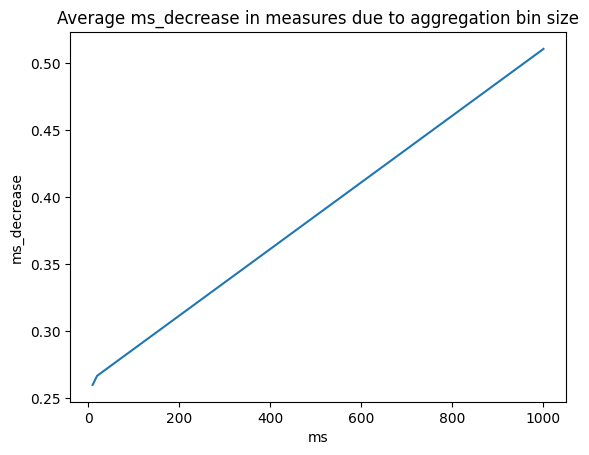

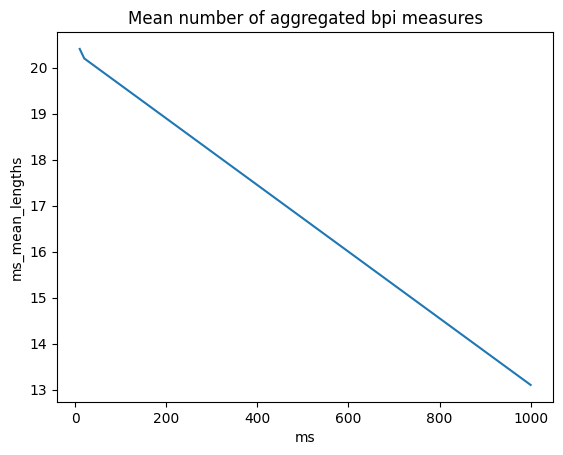

Deleted:  /home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Train/Pre_Processed_Bin_Aggregates-log-scaled/
Created:  /home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Train/Pre_Processed_Bin_Aggregates-log-scaled/
/home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Train/Pre_Processed_Bin_Aggregates-log-scaled/data-0010-ms-aggregate-log-scaled.parquet  saved successfully.
/home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Train/Pre_Processed_Bin_Aggregates-log-scaled/data-0020-ms-aggregate-log-scaled.parquet  saved successfully.
/home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Train/Pre_Processed_Bin_Aggregates-log-scaled/data-1000-ms-aggregate-log-scaled.parquet  saved successfully.


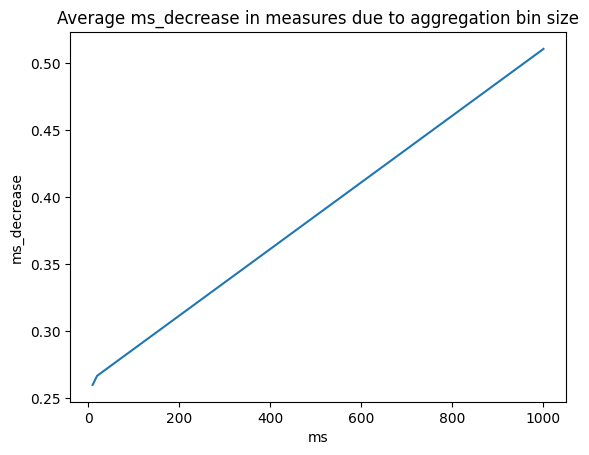

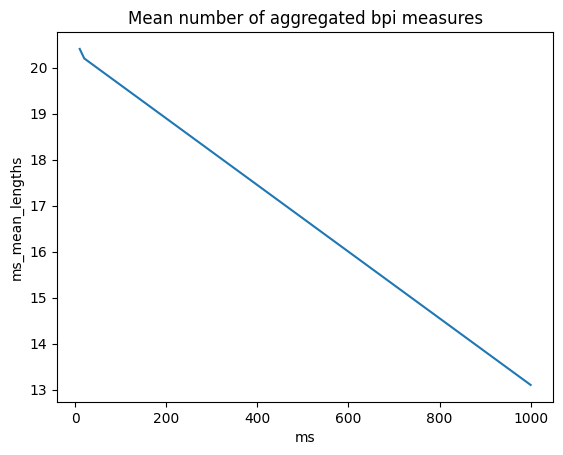

Deleted:  /home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Test/Pre_Processed_Bin_Aggregates/
Created:  /home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Test/Pre_Processed_Bin_Aggregates/
/home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Test/Pre_Processed_Bin_Aggregates/data-0010-ms-aggregate.parquet  saved successfully.
/home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Test/Pre_Processed_Bin_Aggregates/data-0020-ms-aggregate.parquet  saved successfully.
/home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Test/Pre_Processed_Bin_Aggregates/data-1000-ms-aggregate.parquet  saved successfully.


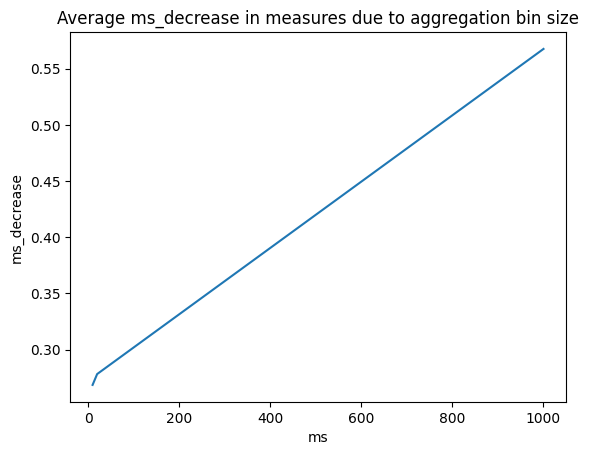

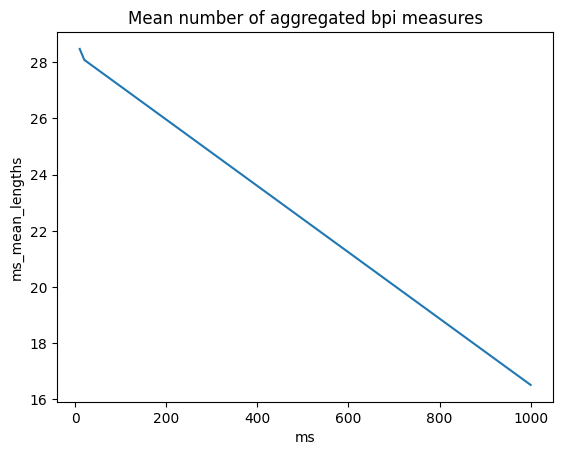

Deleted:  /home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Test/Pre_Processed_Bin_Aggregates-log-scaled/
Created:  /home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Test/Pre_Processed_Bin_Aggregates-log-scaled/
/home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Test/Pre_Processed_Bin_Aggregates-log-scaled/data-0010-ms-aggregate-log-scaled.parquet  saved successfully.
/home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Test/Pre_Processed_Bin_Aggregates-log-scaled/data-0020-ms-aggregate-log-scaled.parquet  saved successfully.
/home/deborahdarragh/Documents/MCM1_Practicum_Data/Open_World/Processed_Data/Test/Pre_Processed_Bin_Aggregates-log-scaled/data-1000-ms-aggregate-log-scaled.parquet  saved successfully.


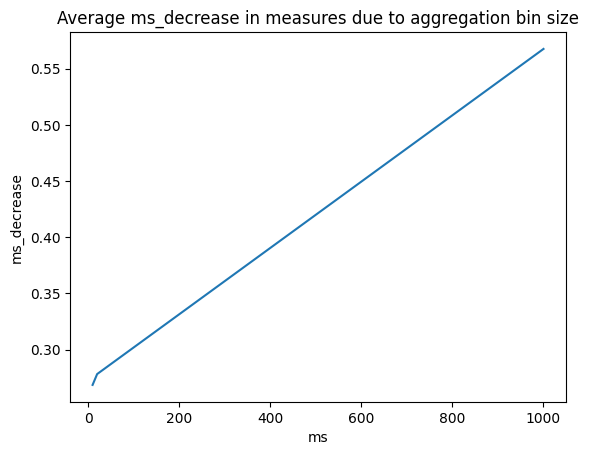

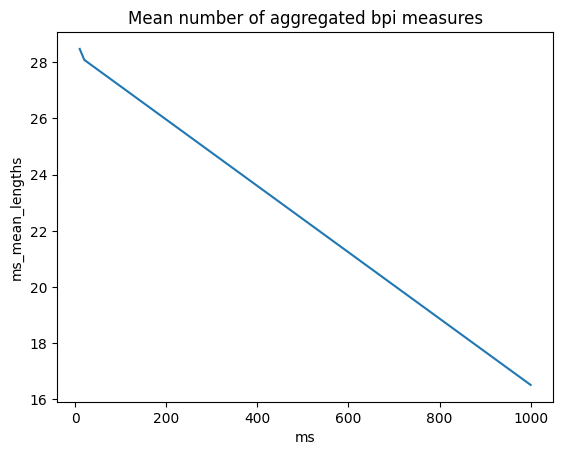

In [30]:
ms_bins = [10,20,1000]
create_binned_data(dataset = train_df, ms_bins = ms_bins, folder_name = binned_data_folder_train)
create_binned_data(dataset = train_df, ms_bins = ms_bins, folder_name = log_scaled_data_folder_train, log_scaled = True)

create_binned_data(dataset = test_df, ms_bins = ms_bins, folder_name = binned_data_folder_test)
create_binned_data(dataset = test_df, ms_bins = ms_bins, folder_name = log_scaled_data_folder_test, log_scaled = True)